## Imports and defaults

In [157]:
import ipyplot

import sys
import os

import rawpy
import cv2
import numpy as np

from skimage.filters import rank, median
from skimage.morphology import disk

BIT_DEPTH = 12

In [17]:
data_root = "../data/"
raw_fp = os.path.join(data_root, "DSC01088.ARW")
jpeg_fp = os.path.join(data_root, "DSC01088.JPG")
assert all(os.path.exists(fp) for fp in [raw_fp, jpeg_fp])
X1, Y1, X2, Y2 = 0, 100, 0, 100

In [133]:
def normalize(img):
    return (img - img.min())/(img.max() - img.min())

## Raw reading & packing

In [4]:
def raw_reader(fp, bit_depth):
    _img = rawpy.imread(fp)
    img = _img.raw_image.copy()
    img = np.expand_dims(img,axis=2)
    black_level = _img.black_level_per_channel[0] # assume all black level is the same
    new_img = (np.minimum(np.maximum(img.astype(np.float32) - black_level , 0) + black_level, 2**BIT_DEPTH - 1) - black_level) / ( (2 ** BIT_DEPTH - 1))
    return new_img

In [5]:
def raw_packer(img):
    H = img.shape[0]
    W = img.shape[1]
    return np.concatenate((img[0:H:2, 0:W:2, :],# R
                img[0:H:2, 1:W:2, :],           # GR
                img[1:H:2, 0:W:2, :],           # GB
                img[1:H:2, 1:W:2, :]), axis=2)  # B

1. Read raw and jpg images
2. Pack raw (RGGB)
3. Get green channels from raw, jpg (approx. illumination)


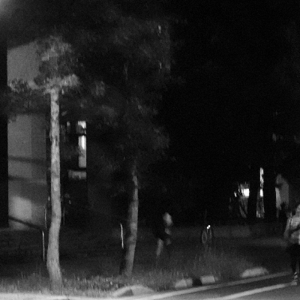
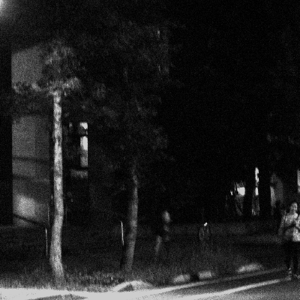


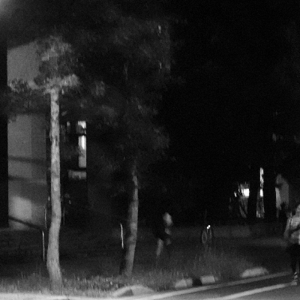
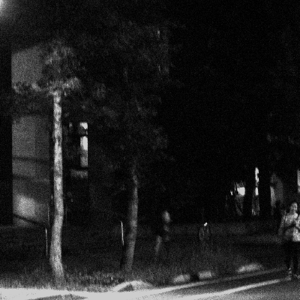

In [102]:
raw = raw_reader(raw_fp, bit_depth = BIT_DEPTH).astype(np.float64)
jpg = (cv2.imread(jpeg_fp)/255)[:,:,::-1]

raw = raw_packer(raw)

raw = cv2.resize(raw, (1200,800))
jpg = cv2.resize(jpg, (1200,800))

X1, Y1, X2, Y2 = 400, 200, 800, 600
raw = raw[Y1:Y2, X1:X2, 1].copy()
jpg = jpg[Y1:Y2, X1:X2, 1].copy()

ipyplot.plot_images([jpg, raw],img_width=300,max_images=3)

In [103]:
raw.max()
jpg.max()

1.0


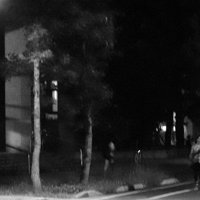
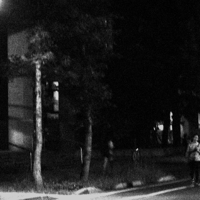
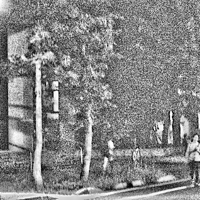
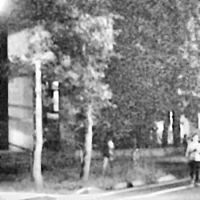


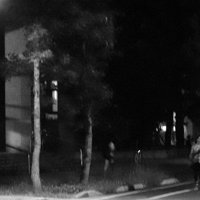
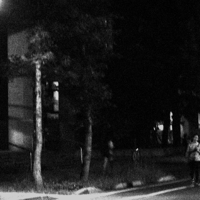
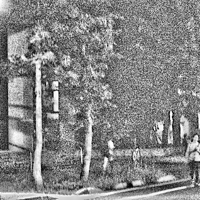
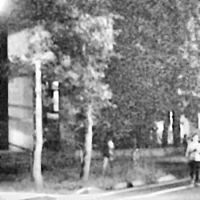

In [171]:
def unsharp_mask(img):
    img_copy = img.copy()
    gaussian_3 = cv2.GaussianBlur(img, (0, 0), 2.0)
    result = cv2.addWeighted(img_copy, 1.5, gaussian_3, -0.5, 0, img_copy)
    return result

enhanced1 = normalize(rank.equalize(normalize(unsharp_mask(raw)), disk(30)))
enhanced2 = normalize(median(rank.equalize(normalize((unsharp_mask(raw))), disk(100)), disk(3)))


ipyplot.plot_images([jpg, raw, enhanced1, enhanced2], img_width=200,max_images=4)


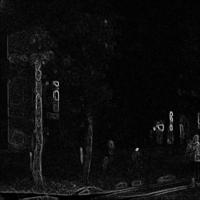
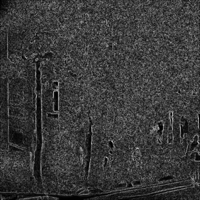
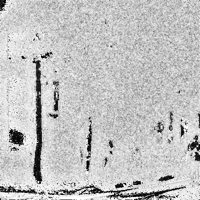
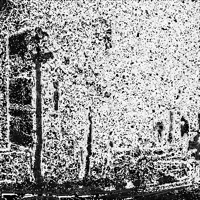
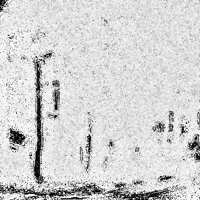
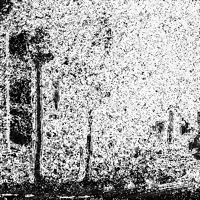


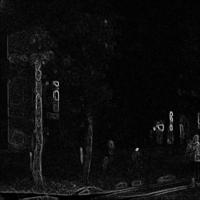
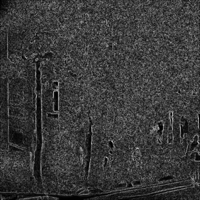
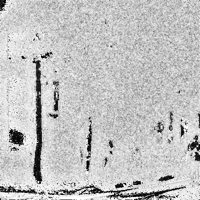
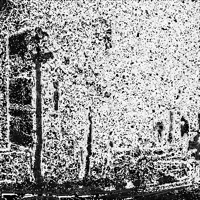
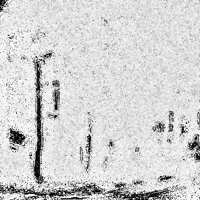
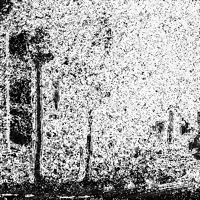

dtype('float64')

In [179]:
def sobel(img):
    grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    return np.abs(grad_x)+np.abs(grad_y)

def grad_diff(img1, img2):
    return normalize(sobel(img1)) - normalize(sobel(img2))

def grad2_diff(img1, img2):
    return normalize(sobel(sobel(img1))) - normalize(sobel(sobel(img2)))

diff1 = grad_diff(raw, enhanced1)
diff2 = grad_diff(raw, enhanced2)

diff3 = grad2_diff(raw, enhanced1)
diff4 = grad2_diff(raw, enhanced2)

ipyplot.plot_images([normalize(sobel(raw)), normalize(sobel(enhanced1)), diff1, diff2, diff3, diff4], img_width=200,max_images=10)
sobel(enhanced).dtype


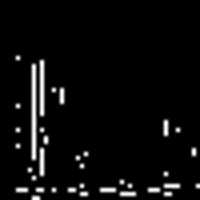
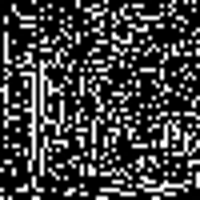
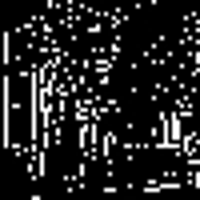


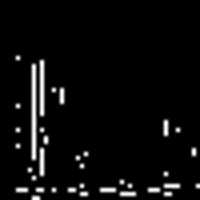
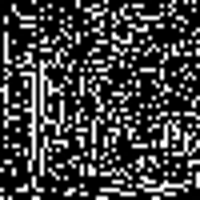
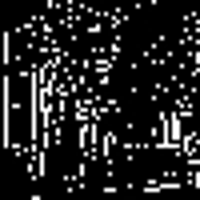

In [205]:
def extended_edge(img):
    ew = cv2.filter2D(img, ddepth=-1, kernel=np.array([[-1, -1, -1],[2,2,2],[-1,-1,-1]]))
    ns = cv2.filter2D(img, ddepth=-1, kernel=np.array([[-1, 2, -1],[-1,2,-1],[-1,2,-1]]))
    nesw = cv2.filter2D(img, ddepth=-1, kernel=np.array([[-1, -1, 2],[-1,2,-1],[2,-1,-1]]))
    nwse = cv2.filter2D(img, ddepth=-1, kernel=np.array([[2, -1, -1],[-1,2,-1],[-1,-1,2]]))
    return ew+ns+nesw+nwse
S=50
ext0 = extended_edge(cv2.resize(raw, (S,S)))
ext1 = extended_edge(cv2.resize(enhanced1, (S,S)))
ext2 = extended_edge(cv2.resize(enhanced2, (S,S)))
ipyplot.plot_images([ext0, ext1, ext2], img_width=200,max_images=10)



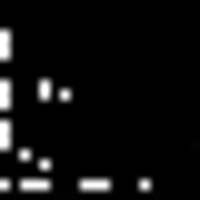
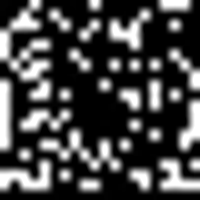
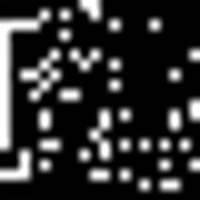


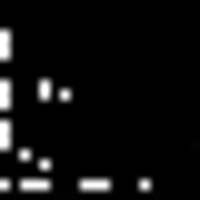
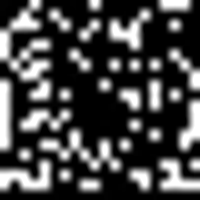
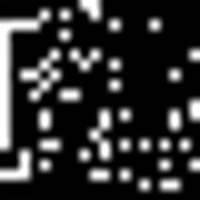

In [206]:
def extended_edge(img):
    ew = cv2.filter2D(img, ddepth=-1, kernel=np.array([[-1, -1, -1],[2,2,2],[-1,-1,-1]]))
    ns = cv2.filter2D(img, ddepth=-1, kernel=np.array([[-1, 2, -1],[-1,2,-1],[-1,2,-1]]))
    nesw = cv2.filter2D(img, ddepth=-1, kernel=np.array([[-1, -1, 2],[-1,2,-1],[2,-1,-1]]))
    nwse = cv2.filter2D(img, ddepth=-1, kernel=np.array([[2, -1, -1],[-1,2,-1],[-1,-1,2]]))
    return ew+ns+nesw+nwse
S=20
ext0 = extended_edge(cv2.resize(raw, (S,S)))
ext1 = extended_edge(cv2.resize(enhanced1, (S,S)))
ext2 = extended_edge(cv2.resize(enhanced2, (S,S)))
ipyplot.plot_images([ext0, ext1, ext2], img_width=200,max_images=10)


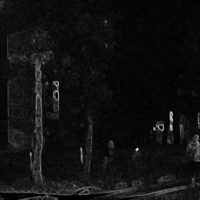
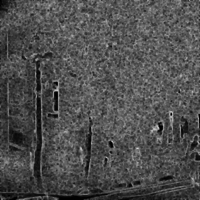
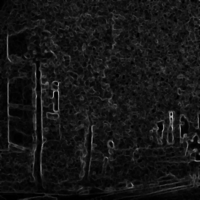


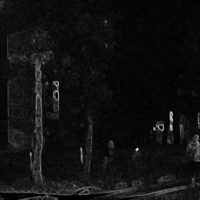
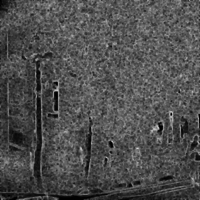
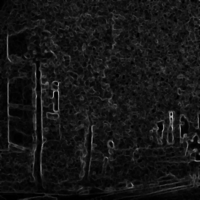

In [218]:
kernel = np.ones((3,3),np.uint8)
morph0 = cv2.morphologyEx(sobel(raw),cv2.MORPH_CLOSE, kernel)
morph1 = cv2.morphologyEx(sobel(enhanced1),cv2.MORPH_CLOSE, kernel)
morph2 = cv2.morphologyEx(sobel(enhanced2),cv2.MORPH_CLOSE, kernel)

ipyplot.plot_images([normalize(morph0), normalize(morph1), normalize(morph2)], img_width=200,max_images=10)

2918.887750666328
4065.4818577766614
1.3928188423308114



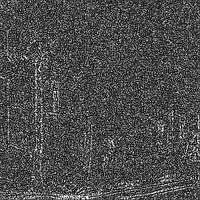
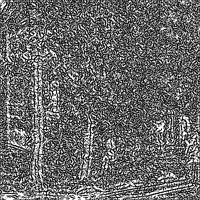


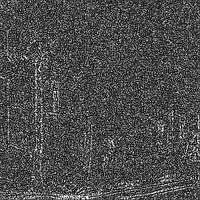
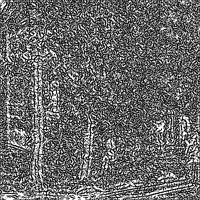

In [231]:
diff_morph1 = 1/(np.abs(sobel(enhanced1) - morph1)+0.0001)
diff_morph2 = 1/(np.abs(sobel(enhanced2) - morph2)+0.0001)

print(diff_morph1.sum()/400**2)
print(diff_morph2.sum()/400**2)
print(diff_morph2.sum()/diff_morph1.sum())

ipyplot.plot_images([normalize(diff_morph1), normalize(diff_morph2)], img_width=200,max_images=10)